# Modelo Machine Learning

Este modelo tiene por objetivo predecir la variable `presunta_infraccion` y `tipo` dado un vector de características. Es decir, el problema es de clasificación, donde se busca encontrar un $\psi:\mathbb{R}^n \to \mathbb{R}^k$. Donde $n$ es el número de `features` y $k$, el número de clases y $X \in \mathbb{R}^n$

In [50]:
import pandas as pd
import numpy as np

path_data = 'data/mdi_detenidos_2024_limpio.csv'
df = pd.read_csv(path_data)
df.shape

(40976, 8)

In [51]:
df.head()

,tipo,estado_civil,edad,genero,tipo_lugar,codigo_provincia,nombre_provincia,presunta_infraccion
0,APREHENDIDO,SOLTERO/A,19,MASCULINO,ÁREA DE ACCESO PÚBLICO,2,BOLÍVAR,OTROS
1,DETENIDO,CASADO/A,40,MASCULINO,ÁREA PRIVADA,15,NAPO,OTROS
2,APREHENDIDO,SOLTERO/A,36,FEMENINO,OTROS,17,PICHINCHA,OTROS
3,APREHENDIDO,SOLTERO/A,26,MASCULINO,ÁREA DE ACCESO PÚBLICO,17,PICHINCHA,DELITOS CONTRA EL DERECHO A LA PROPIEDAD
4,APREHENDIDO,DIVORCIADO/A,34,MASCULINO,ÁREA DE ACCESO PÚBLICO,1,AZUAY,OTROS


In [52]:
df.dtypes

tipo                   object
estado_civil           object
edad                    int64
genero                 object
tipo_lugar             object
codigo_provincia        int64
nombre_provincia       object
presunta_infraccion    object
dtype: object

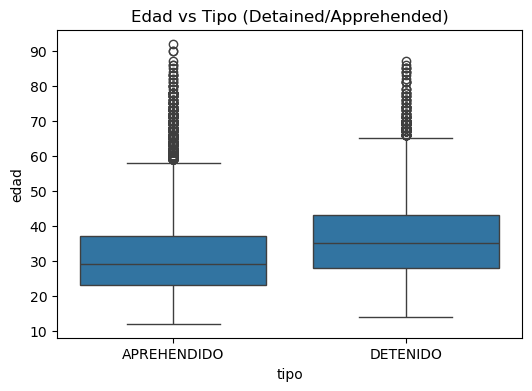

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Numeric correlation (Pearson)
plt.figure(figsize=(6,4))
sns.boxplot(x="tipo", y="edad", data=df)
plt.title("Edad vs Tipo (Detained/Apprehended)")
plt.show()

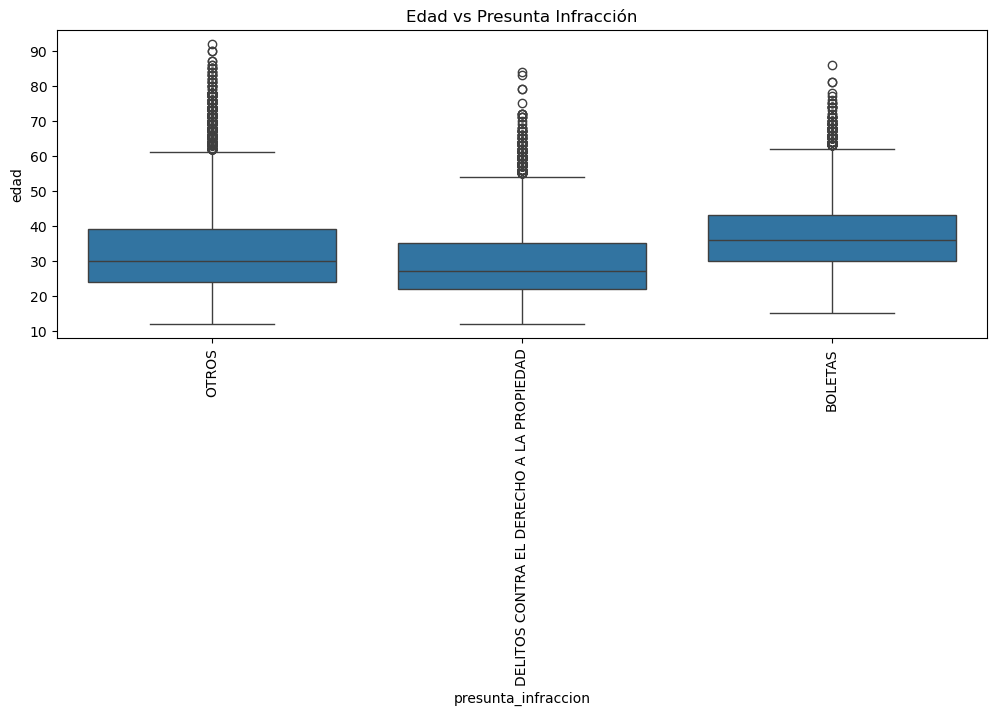

In [54]:
plt.figure(figsize=(12,4))
sns.boxplot(x="presunta_infraccion", y="edad", data=df)
plt.xticks(rotation=90)
plt.title("Edad vs Presunta Infracción")
plt.show()

In [55]:
from scipy.stats import chi2_contingency

# --- Function for Cramér's V (categorical correlation)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt((chi2/n) / (min(k-1, r-1)))

# Compute categorical correlations with targets
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if col not in ["tipo","presunta_infraccion"]:
        print(f"{col} vs tipo (Cramér's V): {cramers_v(df[col], df['tipo']):.3f}")
        print(f"{col} vs presunta_infraccion (Cramér's V): {cramers_v(df[col], df['presunta_infraccion']):.3f}")

estado_civil vs tipo (Cramér's V): 0.191
estado_civil vs presunta_infraccion (Cramér's V): 0.154
genero vs tipo (Cramér's V): 0.033
genero vs presunta_infraccion (Cramér's V): 0.056
tipo_lugar vs tipo (Cramér's V): 0.156
tipo_lugar vs presunta_infraccion (Cramér's V): 0.148
nombre_provincia vs tipo (Cramér's V): 0.132
nombre_provincia vs presunta_infraccion (Cramér's V): 0.151


In [56]:
df.drop(columns=["codigo_provincia"], inplace=True)
df.shape

(40976, 7)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Encode categorical features
df_encoded = df.copy()
encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le


# Features and targets
X = df_encoded.drop(["tipo","presunta_infraccion"], axis=1)

y_tipo = df_encoded["tipo"]
y_infraccion = df_encoded["presunta_infraccion"]

X.shape, y_tipo.shape, y_infraccion.shape

((40976, 5), (40976,), (40976,))

In [58]:
X.sample(5)

,estado_civil,edad,genero,tipo_lugar,nombre_provincia
33423,3,40,1,2,15
928,3,24,1,0,13
14828,3,36,1,3,9
8192,0,30,1,2,19
3584,1,32,1,2,2


In [59]:
# Example: print mapping for "presunta_infraccion"
this_feature = "estado_civil"
print(dict(zip(encoders[this_feature].classes_, 
               encoders[this_feature].transform(encoders[this_feature].classes_))))

{'CASADO/A': 0, 'DIVORCIADO/A': 1, 'SE DESCONOCE': 2, 'SOLTERO/A': 3, 'UNIÓN DE HECHO': 4, 'VIUDO/A': 5}


In [60]:
# Example: print mapping for "presunta_infraccion"
this_feature = "tipo_lugar"
print(dict(zip(encoders[this_feature].classes_, 
               encoders[this_feature].transform(encoders[this_feature].classes_))))

{'OTROS': 0, 'VIVIENDA/ALOJAMIENTO': 1, 'ÁREA DE ACCESO PÚBLICO': 2, 'ÁREA PRIVADA': 3}


In [61]:
# Example: print mapping for "presunta_infraccion"
this_feature = "nombre_provincia"
print(dict(zip(encoders[this_feature].classes_, 
               encoders[this_feature].transform(encoders[this_feature].classes_))))

{'AZUAY': 0, 'BOLÍVAR': 1, 'CARCHI': 2, 'CAÑAR': 3, 'CHIMBORAZO': 4, 'COTOPAXI': 5, 'EL ORO': 6, 'ESMERALDAS': 7, 'GALÁPAGOS': 8, 'GUAYAS': 9, 'IMBABURA': 10, 'LOJA': 11, 'LOS RÍOS': 12, 'MANABÍ': 13, 'MAR TERRITORIAL': 14, 'MORONA SANTIAGO': 15, 'NAPO': 16, 'ORELLANA': 17, 'PASTAZA': 18, 'PICHINCHA': 19, 'SANTA ELENA': 20, 'STO DGO DE LOS TSÁCHILAS': 21, 'SUCUMBÍOS': 22, 'TUNGURAHUA': 23, 'ZAMORA CHINCHIPE': 24}


In [62]:
# Example: print mapping for "presunta_infraccion"
this_feature = "tipo"
tipo_dict = dict(zip(encoders[this_feature].classes_, 
               encoders[this_feature].transform(encoders[this_feature].classes_)))
tipo_dict

{'APREHENDIDO': 0, 'DETENIDO': 1}

In [63]:
# Example: print mapping for "presunta_infraccion"
this_feature = "presunta_infraccion"
presunta_infraccion_dict = dict(zip(encoders[this_feature].classes_, 
               encoders[this_feature].transform(encoders[this_feature].classes_)))
presunta_infraccion_dict

{'BOLETAS': 0, 'DELITOS CONTRA EL DERECHO A LA PROPIEDAD': 1, 'OTROS': 2}

In [64]:
# --- Train/test split
X_train, X_test, y_tipo_train, y_tipo_test = train_test_split(X, y_tipo, test_size=0.2, random_state=42)
X_train2, X_test2, y_infr_train, y_infr_test = train_test_split(X, y_infraccion, test_size=0.2, random_state=42)

In [65]:
X_train.shape, X_test.shape, y_tipo_train.shape, y_tipo_test.shape

((32780, 5), (8196, 5), (32780,), (8196,))

In [66]:
# --- Model 1: tipo (binary)
rf_tipo = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf_tipo.fit(X_train, y_tipo_train)
y_tipo_pred = rf_tipo.predict(X_test)
print("=== Tipo (Detained vs Apprehended) ===")
print(classification_report(y_tipo_test, y_tipo_pred))

=== Tipo (Detained vs Apprehended) ===
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      6215
           1       0.36      0.52      0.42      1981

    accuracy                           0.66      8196
   macro avg       0.59      0.61      0.59      8196
weighted avg       0.71      0.66      0.68      8196



In [67]:
# --- Model 2: presunta_infraccion (multiclass)
rf_infr = RandomForestClassifier(n_estimators=20, random_state=42, class_weight="balanced")
rf_infr.fit(X_train2, y_infr_train)
y_infr_pred = rf_infr.predict(X_test2)
print("=== Presunta Infracción (Crime Category) ===")
print(classification_report(y_infr_test, y_infr_pred))

=== Presunta Infracción (Crime Category) ===
              precision    recall  f1-score   support

           0       0.27      0.48      0.35      1211
           1       0.27      0.42      0.33      1417
           2       0.77      0.53      0.63      5568

    accuracy                           0.51      8196
   macro avg       0.44      0.48      0.44      8196
weighted avg       0.61      0.51      0.54      8196

